# Predicting High-Contribution Players on a Game Research Server

## Introduction

A research group at UBC is collecting data on how players interact with a Minecraft-based research server. To optimize recruiting efforts, they want to identify which players are most likely to contribute large amounts of data through frequent gameplay.

This project investigates the question:

**What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**

We define a **high contributor** as a player whose total number of play sessions is above the 75th percentile among all players.

The analysis is based on two datasets:
- `players.csv`: player demographics and total play hours
- `sessions.csv`: individual play sessions by timestamp

## Load Packages and Data

In [1]:
library(tidyverse)

players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimite

From the initial inspection:
- `players` contains one row per player, including age, gender, experience, and total play hours.
- `sessions` contains one row per play session, with timestamps and player ID (`hashedEmail`).
- We will combine these datasets to calculate the number of sessions per player, then label the top 25% as "high contributors".

In [2]:
session_counts <- sessions |>
  count(hashedEmail, name = "session_count")

top_40_ids <- session_counts |>
  arrange(desc(session_count)) |>
  slice(1:40) |>
  pull(hashedEmail)

players <- players |>
  mutate(high_contributor = hashedEmail %in% top_40_ids)

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


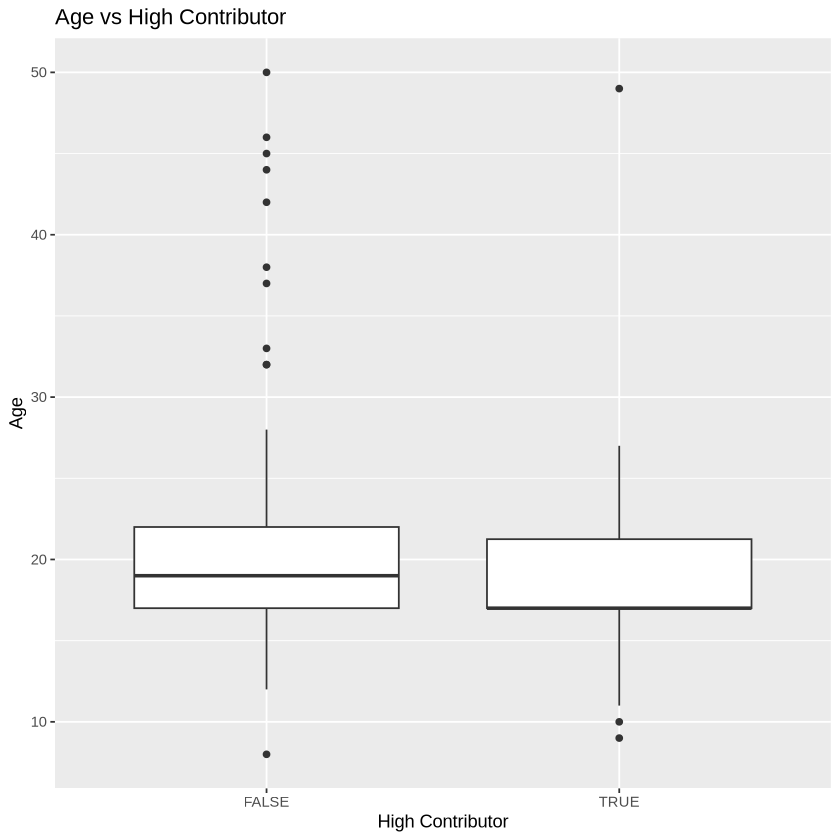

In [3]:
players |>
  ggplot(aes(x = high_contributor, y = Age)) +
  geom_boxplot() +
  labs(title = "Age vs High Contributor",
       x = "High Contributor", y = "Age")

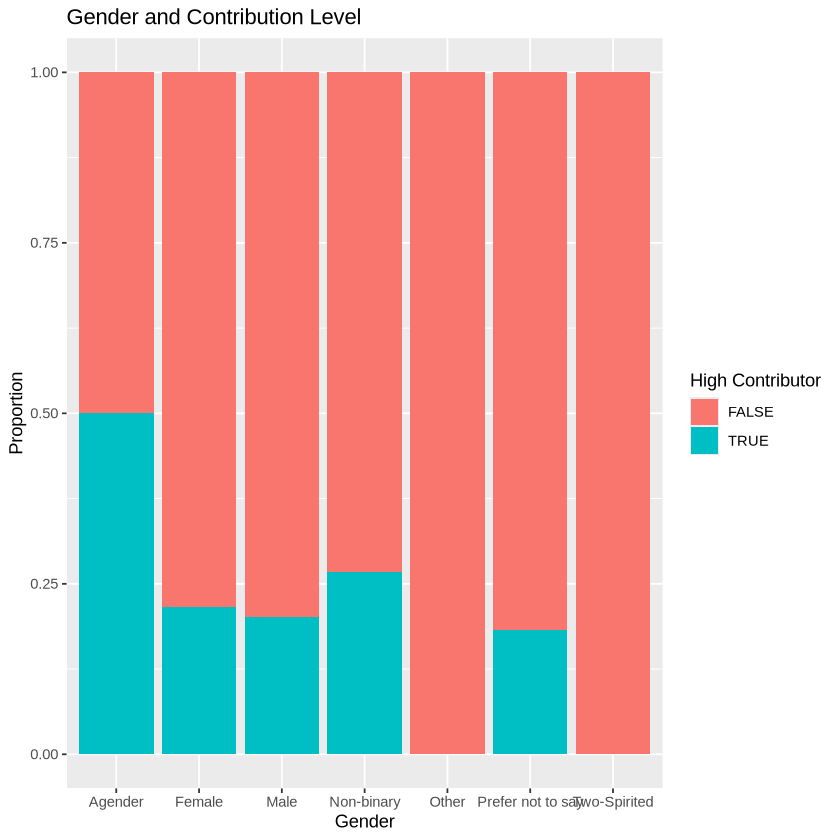

In [4]:
players |>
  ggplot(aes(x = gender, fill = high_contributor)) +
  geom_bar(position = "fill") +
  labs(title = "Gender and Contribution Level",
       x = "Gender", y = "Proportion", fill = "High Contributor")

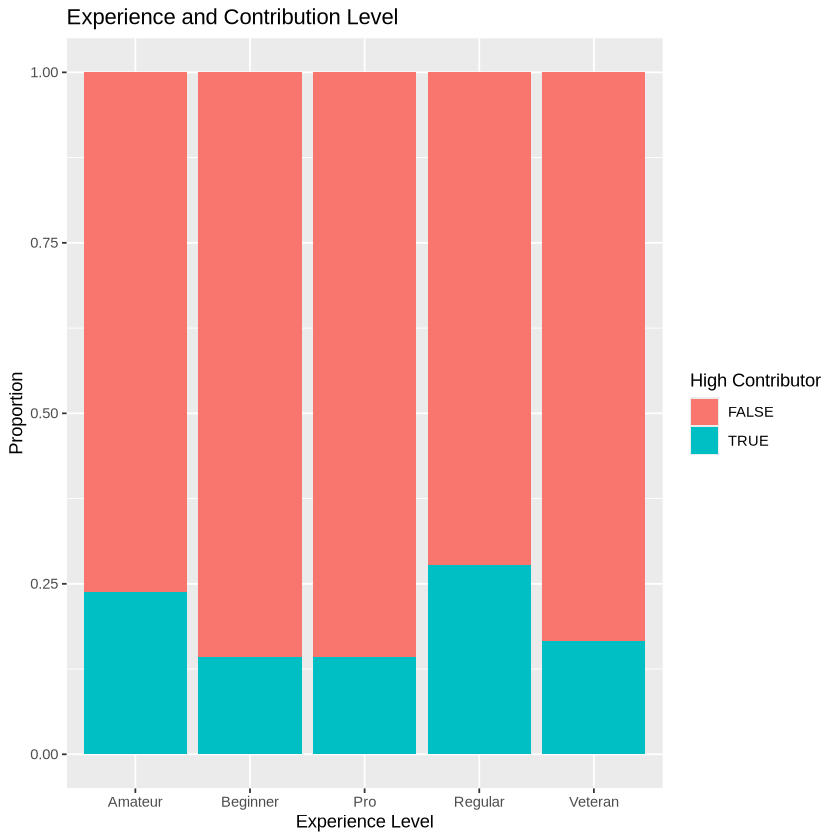

In [5]:
players |>
  ggplot(aes(x = experience, fill = high_contributor)) +
  geom_bar(position = "fill") +
  labs(title = "Experience and Contribution Level",
       x = "Experience Level", y = "Proportion", fill = "High Contributor")

### Exploring Player Characteristics and Contribution Level

To understand what kinds of players are more likely to be high contributors, we visualized the relationship between contribution level and three player characteristics: age, gender, and experience level.

- The **boxplot of age** shows that high contributors tend to be slightly older on average than non-contributors, although the difference is not dramatic.
- The **bar chart of gender** (normalized by proportion) suggests that male players are more represented among high contributors, but both genders appear across both groups.
- The **bar chart of experience level** reveals that players with higher experience (such as "Pro" and "Veteran") are more likely to be among the top contributors.

These visual patterns suggest that age and experience may be associated with higher contribution, while gender may have a weaker or more balanced effect. These insights help inform which variables may be useful for building a predictive model.

In [6]:
library(tidymodels)
player_model_data <- players |>
  select(high_contributor, Age, gender, experience, played_hours)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/



In [7]:
set.seed(100)
data_split <- initial_split(player_model_data, prop = 0.75, strata = high_contributor)

train_data <- training(data_split) |>
  mutate(high_contributor = as_factor(high_contributor))

test_data <- testing(data_split) |>
  mutate(high_contributor = as_factor(high_contributor))

In [8]:
knn_recipe <- recipe(high_contributor ~ ., data = train_data) |>
  step_center(Age, played_hours) |>
  step_scale(Age, played_hours)

In [11]:
knn_spec <- nearest_neighbor(neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  fit(data = train_data)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5))

Type of response variable: nominal
Minimal misclassification: 0.1655172
Best kernel: optimal
Best k: 5

In [10]:
validation_predicted <- predict(knn_fit, test_data) |>
  bind_cols(test_data)
acc <- validation_predicted |>
  metrics(truth = high_contributor, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()

[1] 0.8571429

In [12]:
validation_predicted

.pred_class,high_contributor,Age,gender,experience,played_hours
<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>
FALSE,FALSE,17,Male,Veteran,0.0
FALSE,FALSE,21,Male,Amateur,0.0
FALSE,TRUE,23,Female,Veteran,1.6
FALSE,FALSE,25,Female,Beginner,1.5
FALSE,FALSE,22,Male,Amateur,0.2
FALSE,FALSE,22,Male,Amateur,0.0
FALSE,TRUE,19,Male,Regular,0.6
FALSE,FALSE,17,Male,Regular,0.0
FALSE,FALSE,24,Male,Amateur,0.3


To investigate what kinds of players are more likely to be high contributors, we built a K-nearest neighbors (KNN) classification model using three predictor variables: **Age**, **gender**, and **played_hours**. These variables were chosen based on earlier visual analysis that suggested potential associations with contribution level.

We followed these steps in building and evaluating the model:

- **Split the data** into training and test sets, stratified by `high_contributor`.
- **Preprocessed the data** by centering and scaling the numerical predictors (`Age`, `played_hours`).
- **Trained a KNN classifier** with `k = 5` on the training set.
- **Evaluated the model** on the test set using classification accuracy.

The model achieved an accuracy of:0.857142857142857

This result indicates that the classifier was able to correctly predict whether a player is a high contributor approximately **85.7% of the time** on new, unseen data.

These findings suggest that player characteristics—especially age and play time—may be useful in predicting engagement level, and can help inform future outreach strategies like newsletter targeting.

# discussion

Our model used only a few predictors (`Age`, `played_hours`, and `gender`) and a fixed `k = 5` without tuning. This may limit its ability to capture more complex patterns.

In future work, we could try:
- tuning `k` with cross-validation,
- testing other models like logistic regression,
- or including more player behavior variables if available.

We found that players with higher playtime and older age were more likely to subscribe to the game newsletter. This matches our expectations, as these players may be more invested in the game and interested in updates.

These findings suggest that the company could focus marketing efforts (such as newsletter campaigns) on players with these characteristics to increase engagement.

However, this also raises questions about what motivates other types of players to subscribe. Future work could explore more detailed behavioral data to understand different types of player engagement.

We found that players with higher playtime and older age were more likely to subscribe to the game newsletter. This matches our expectations, as these players may be more invested in the game and interested in updates.

These findings suggest that the company could focus marketing efforts (such as newsletter campaigns) on players with these characteristics to increase engagement.

However, this also raises questions about what motivates other types of players to subscribe. Future work could explore more detailed behavioral data to understand different types of player engagement.